In [132]:
import numpy as np
import matplotlib.pyplot as plt

Approach adapted from https://www.labri.fr/perso/nrougier/from-python-to-numpy/#boids

### Begin with a 2D LJ simulation

This will be a 2-dimensional simulation of Lennard-Jones particles using all dimensionless parameters:
* Time step $t = 1$
* Particle mass $m = 1$
* Temperature $T = 1$
* LJ potential width $\sigma=1$
* LJ potential depth $\epsilon=1$

In [43]:
# Define dimensionless parameters
t = 1.
m = 1.
kB = 1  # Boltzmann constant
L = 10.  # Simulation box size

In [228]:
# Define simulation settings
T = 1.
sigma = 1.
epsilon = 1.
rcut = 4.
assert(rcut < L/2)

In [247]:
n = 25

In [256]:
()

10.0

In [259]:
# Initialize positions
position = np.zeros((n, 2), dtype=np.float32)
nside = int(np.sqrt(n))  # For now, just assume sqrt(n) is integer... deal with general case later
lside = (4./5.) * L  # Shrink initial lattice slightly to avoid overlap of periodic images
x = np.linspace(-lside/2, lside/2, nside)
y = np.linspace(-lside/2, lside/2, nside)
X,Y = np.meshgrid(x,y)
pos_init = np.array([X.flatten(),Y.flatten()]).T
position += pos_init

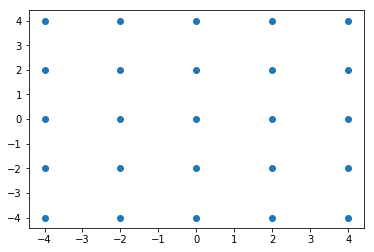

In [260]:
# Visualize uniform initial positions in simulation box
plt.scatter(position[:,0], position[:,1])

In [261]:
# Initialize velocities to uniform distribution with zero mean
velocity = np.zeros((n, 2), dtype=np.float32)
velocity += np.random.uniform(-.5, .5, size=(n, 2))  # Uniform random velocities
velocity -= np.mean(velocity) # Subtract the mean (no bulk flow)
# for i in range(velocity.shape[1]):
#     velocity[:,i] /= np.mean(velocity[:,i]**2)  # Scale the velocities to get desired initial temperature

In [262]:
# Determine particles within cutoff radius
dx = np.subtract.outer(position[:, 0], position[:, 0])
dy = np.subtract.outer(position[:, 1], position[:, 1])

# Apply "minimum image" convention -- particles interact only with nearest periodic image
dx[dx > L/2] -= L
dx[dx < -L/2] += L

dy[dy > L/2] -= L
dy[dy < -L/2] += L

r2 = dx**2 + dy**2  # Squared distance between all pairs of particles

In [269]:
# Select interaction pairs within cutoff distance (ignoring self-interactions)
mask = r2 < rcut**2
mask *= r2 > 0

In [270]:
int(dx/L)

TypeError: only size-1 arrays can be converted to Python scalars

In [27]:
# Compute forces
energy = 

dtype('float32')